**Inteligencia Artificial avanzada para la Ciencia de Datos - TC3006C**

**Tecnológico de Monterrey, Campus Monterrey**

**Portafolio de Análisis - Módulo 1**

Cristofer Becerra Sánchez - A01638659

# Resumen

El vertiginoso crecimiento de campos como la Ciencia de Datos provoca preguntas interesantes sobre el mercado laboral de áreas emergentes como esta; específico, preguntas como ¿el salario promedio de un Data Engineer es mayor al de un Data Scientist?, ¿hay diferencia significativa en el salario promedio en función de la experiencia?, y ¿el salario promedio ofrecido por una empresa en Estados Unidos es mayor que en Reino Unido? Tales preguntas ayudan a esclarecer las diferentes condiciones en las cuales un profesionista de esta área puede conseguir un mejor salario. Para contestar las preguntas se implementó un modelo estadístico: la prueba de hipótesis. Esta se utilizó para realizar pruebas de normalidad de las muestras, pruebas de varianzas iguales, y, finalmente, pruebas de diferencias de medias. Se encontró que no hay diferencia significativa entre el salario promedio de un Data Engineer y un Data Scientist con el mismo nivel de experiencia; además, se encontró que el salario promedio de un empleado intermedio en una empresa Estadounidense es mayor al de un empleado principiante; finalmente, se encontró que el salario promedio ofrecido por una empresa mediana en Estados Unidos es mayor que en Reino Unido. 

# Introducción

La Ciencia de Datos sigue siendo un campo relativamente nuevo que sin duda alguna ha crecido en las últimas décadas. Este vertiginoso crecimiento provoca preguntas interesantes sobre el mercado laboral de áreas emergentes como esta. A partir de una base de datos de [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries), es posible elucidar sobre posibles factores que influyen en un mayor o menor salario para un analista de datos o semejante. El presente trabajo establece las siguientes preguntas de investigación:

1. ¿El salario promedio en Estados Unidos de un Data Engineer es mayor al salario promedio de un Data Scientist con el mismo nivel de experiencia?
2. ¿Hay diferencia significativa en el salario promedio en función de la experiencia en una empresa Estadounidense? En particular, ¿el salario promedio de un empleado intermedio es mayor que el salario promedio de un empleado principiante?
3. ¿El salario promedio ofrecido en una empresa mediana en Estados Unidos es mayor al que ofrece una empresa mediana en Reino Unido?

Cada pregunta pretende investigar tres diferentes factores puntuales de las distintas características del conjunto: el puesto (en este caso Data Scientist y Data Engineer), el nivel de experiencia (intermedio y principiante), y ubicación de la empresa (Estados Unidos y Gran Bretaña). Además se realiza un intento de homogeneizar las muestras, es decir un "control" rudimentario: utilizar un mismo nivel de experiencia para comparar los puestos, usar sólo empresas Estadounidenses para comparar los niveles de experiencias, y usar sólo empresas medianas para comparar la ubicación de las empresas.

El objeto de investigación del presente reporte y similares es de suma importancia ya que da una idea sobre los potenciales cursos de acción de los futuros profesionistas de esta área para maximizar su desarrollo profesional y económico; además, este tipo de investigación puede ser de utilidad para diagnosticar las tendencias del mercado en el área de tecnología, y potencialmente orientar a inversionistas y emprendedores de las áreas de oportunidad en esta industria (y quizá incluso en otras).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.dpi'] = 150

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest

In [2]:
colNames = ["ID", "WorkYear", "ExperienceLevel", "EmploymentType", "JobTitle", "Salary", "Currency", "SalaryUSD", "Residence", "RemoteRatio", "CompanyLocation", "CompanySize"]

url = "https://raw.githubusercontent.com/crisb-7/Data-Science-Salaries/main/ds_salaries.csv"

df = pd.read_csv(url, names = colNames, header = 0)

In [3]:
q3, q1 = np.percentile(df.SalaryUSD, [75 ,25])
iqr = q3 - q1
# print("Límite de datos atípicos:", q3 + 1.5*iqr)

In [4]:
#df = df.loc[df.SalaryUSD < q3 + 1.5*iqr]
df = df.where(df.SalaryUSD < q3 + 1.5*iqr)

In [5]:
df = df.drop(columns = ["Salary", "EmploymentType", "Currency", "Residence", "RemoteRatio"])

In [6]:
df["SalaryUSD"] = (df.SalaryUSD - df.SalaryUSD.mean())/df.SalaryUSD.std()

# Análisis estadístico - Pregunta 1
¿El salario promedio en Estados Unidos de un Data Engineer es mayor al salario promedio de un Data Scientist con el mismo nivel de experiencia?
1. **Caso 1**: nivel de experiencia Experto (SE)
2. **Caso 2**: nivel de experiencia Intermedio (MI)

In [7]:
P1 = df.groupby("JobTitle").get_group("Data Scientist")
P1 = pd.concat([P1, df.groupby("JobTitle").get_group("Data Engineer")])
#P1 = P1.groupby("CompanyLocation").get_group("US")
P1 = P1.drop(columns = ["WorkYear", "CompanySize"])
# P1.head(-1)

## Senior Level

Se aborda el primer caso enunciado, la comparación del salario promedio entre un Data Scientist y un Data Engineer para un mismo nivel de experiencia: experto.

In [8]:
P1_Senior = P1.groupby("ExperienceLevel").get_group("SE")

In [9]:
P1_Senior.JobTitle.value_counts()

Data Engineer     63
Data Scientist    60
Name: JobTitle, dtype: int64

Se tiene una distribución casi uniforme de los puestos. Se despliegan la media y desviación estándar de cada sub-subconjunto:

In [10]:
seniorDataScientists = P1_Senior.groupby("JobTitle").get_group("Data Scientist").SalaryUSD
seniorDataScientists.describe()[1:3]

mean    0.708473
std     0.833508
Name: SalaryUSD, dtype: float64

In [11]:
seniorDataEngineers = P1_Senior.groupby("JobTitle").get_group("Data Engineer").SalaryUSD
seniorDataEngineers.describe()[1:3]

mean    0.510063
std     0.798504
Name: SalaryUSD, dtype: float64

Vale la pena notar la gran similitud de la desviación estándar, además de que las medias difieren 0.2 desviaciones estándar de la media.

### Pruebas de normalidad

Antes de proceder directamente con la prueba de hipótesis, se realiza una prueba de bondad de ajuste a una distribución normal con la finalidad de realizar la prueba de hipótesis de las medias con la distribución correcta. Las hipótesis de tal prueba de bondad de ajuste toman la forma

$$
H_0: f(x) = f_0(x) \\
H_a: f(x) \neq f_0(x)
$$

donde $f(x)$ es la distribución de los datos, y $f_0(x)$ es una distribución normal. Se implementará una prueba de normalidad de Shapiro-Wilk para todo el análisis posterior con un nivel de significancia $\alpha = 0.05$. Primero para los salarios de los Data Scientists:

Alpha: 0.05
p-value: 0.5407


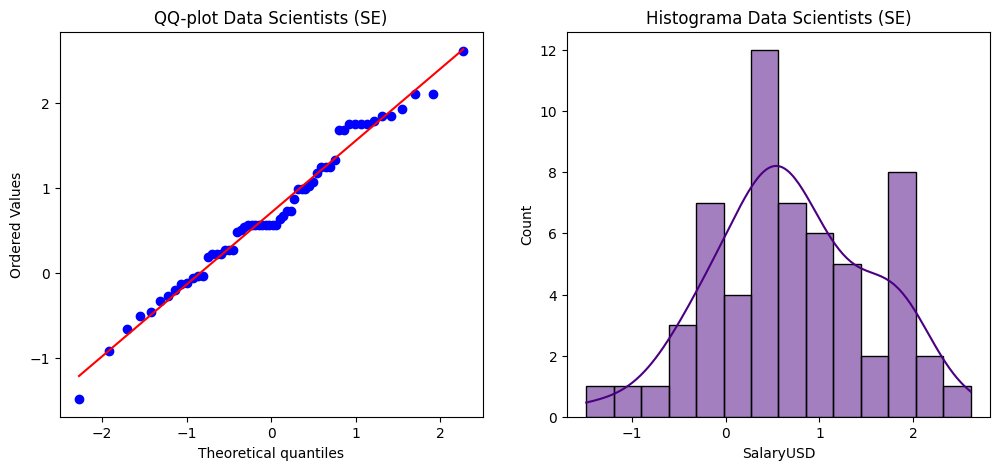

In [12]:
stat, pvalue = stats.shapiro(seniorDataScientists.dropna())
print("Alpha: 0.05")
print("p-value: " + str(round(pvalue, 4)))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(seniorDataScientists.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Data Scientists (SE)")

sns.histplot(seniorDataScientists.dropna(), bins = 14, color="indigo", kde = True, ax = axes[1])
axes[1].set_title("Histograma Data Scientists (SE)")

plt.show()

La prueba retorna un p-value mayor que el nivel de significancia establecido, por lo cual no es posible rechazar $H_0$. Por lo tanto, se dice que los salarios de los Data Scientists siguen una distribución normal. Se realiza lo mismo para los salarios de los Data Engineers,

Alpha: 0.05
p-value: 0.8384


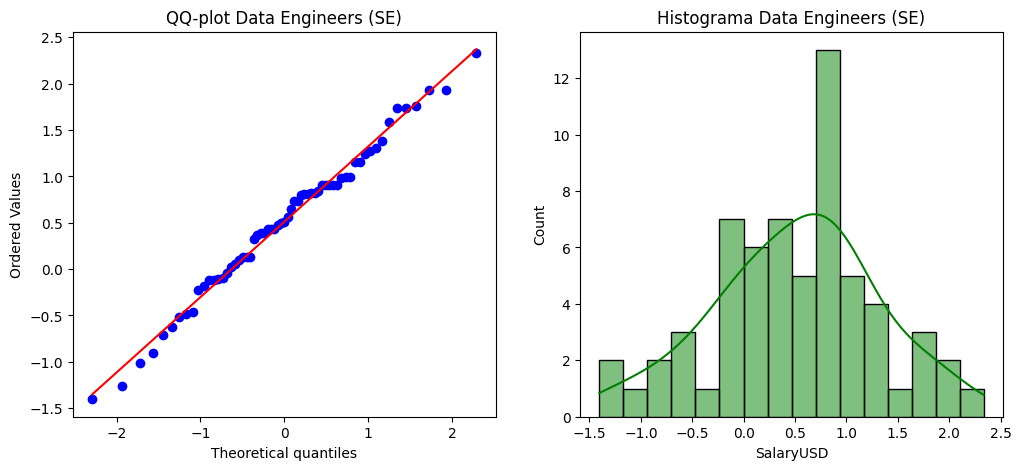

In [13]:
stat, pvalue = stats.shapiro(seniorDataEngineers.dropna())
print("Alpha: 0.05")
print("p-value: " + str(round(pvalue, 4)))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(seniorDataEngineers.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Data Engineers (SE)")

sns.histplot(seniorDataEngineers.dropna(), bins = 16, color="green", kde = True, ax = axes[1])
axes[1].set_title("Histograma Data Engineers (SE)")

plt.show()

observando que puede decirse lo mismo: no se rechaza $H_0$ y por lo tanto los salarios de los Data Engineers se distribuyen normalmente.

### Prueba de hipótesis de varianza

Es conveniente realizar una prueba de hipótesis de varianza, ya que la prueba de hipótesis de las medias cambia significativamente si las varianzas difieren. Entonces, se opta por una prueba de Levene con un $\alpha = 0.05$,

In [14]:
#Prueba de varianzas entre las distribuciones
levene_stat, l_pvalue = stats.levene(seniorDataScientists, seniorDataEngineers)
print("Alpha: 0.05")
print("p-value: " + str(round(l_pvalue, 4)))

Alpha: 0.05
p-value: 0.8458


No se rechaza $H_0$, por lo cual puede afirmarse con un nivel de significancia del 95% que las varianzas poblacionales son iguales.

### Prueba de hipótesis

Se procede entonces con la siguiente prueba de hipótesis

$H_o: ~\mu_1 = \mu_2$,

$H_1: ~\mu_1 > \mu_2$,

donde $\mu_1$ es el salario promedio (poblacional) de un Data Engineer, y $\mu_2$ es el salario promedio (poblacional) de un Data Scientist. Para un $\alpha = 0.05$.

In [15]:
#Prueba z
z0, pvalue = ztest(seniorDataScientists, seniorDataEngineers, value = 0)
print("Estadístico z:", round(z0, 4))
print("Alpha:         0.05")
print("p-value:      ", round(pvalue, 4))

Estadístico z: 1.3483
Alpha:         0.05
p-value:       0.1776


Del estadístico de prueba Z y su respectivo p-value se aduce que no se rechaza la hipótesis nul $H_0$. No hay evidencia suficiente para afirmar que el sueldo promedio de un Data Engineer es mayor al de un Data Scientist (sin controlar para otros posibles factores). Se puede obtener una intuición al graficar sus distribuciones sobrepuestas mediante un histograma (y un boxplot):

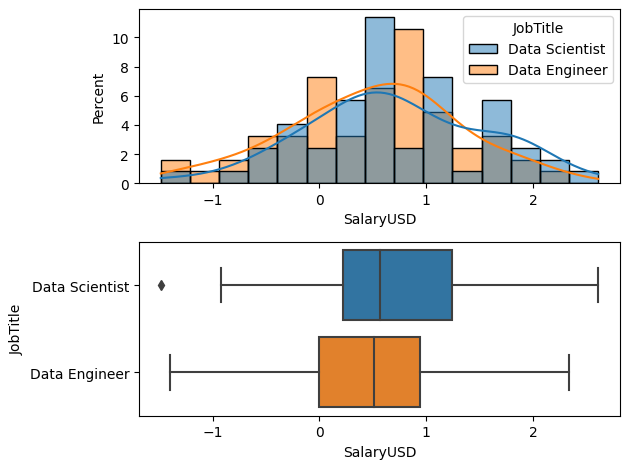

In [16]:
fig, ax = plt.subplots(2, 1)
sns.histplot(data = P1_Senior, x = "SalaryUSD", kde = True, stat = "percent", hue = "JobTitle", ax = ax[0], bins = 15)
sns.boxplot(data = P1_Senior, x = "SalaryUSD", y = "JobTitle", ax = ax[1])
plt.tight_layout()
plt.show()

De esta forma se vuelve evidente la conclusión, ya que los datos se concentran prácticamente en la misma región, con algunas desviaciones insignificantes.

## Intermediate Level

Se prosigue el análisis para los salarios del grupo de nivel intermedio. De igual forma se extraen los vectores para el análsis.

In [17]:
P1_Inter = P1.groupby("ExperienceLevel").get_group("MI")

In [18]:
P1_Inter.JobTitle.value_counts()

Data Scientist    60
Data Engineer     53
Name: JobTitle, dtype: int64

Calculamos la media y desviación estándar de los Data Scientists:

In [19]:
interDataScientists = P1_Inter.groupby("JobTitle").get_group("Data Scientist").SalaryUSD
interDataScientists.describe()[1:3]

mean   -0.429161
std     0.800430
Name: SalaryUSD, dtype: float64

Ahora se compara con la media y desviación estándar de los Data Engineers:

In [20]:
interDataEngineers = P1_Inter.groupby("JobTitle").get_group("Data Engineer").SalaryUSD
interDataEngineers.describe()[1:3]

mean   -0.361763
std     0.759592
Name: SalaryUSD, dtype: float64

### Pruebas de normalidad

Estadístico W: 0.9718
Alpha: 0.05
p-value:  0.1783


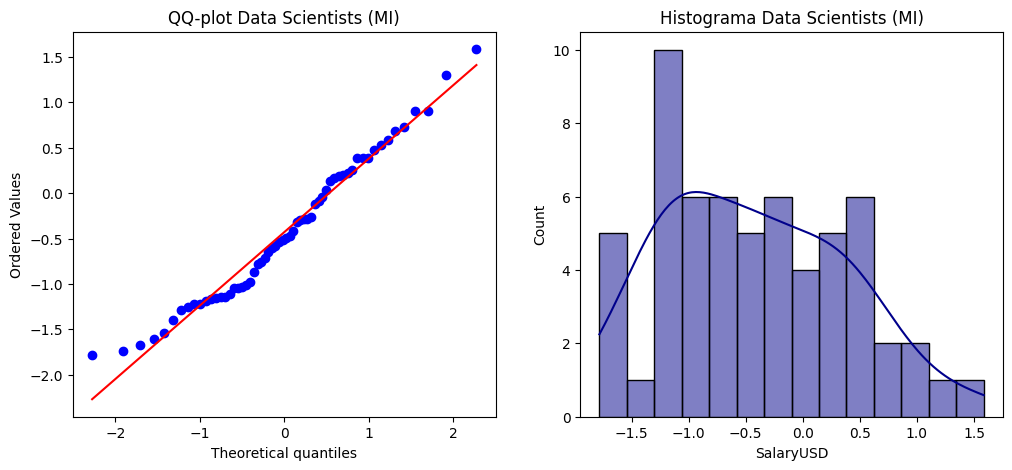

In [21]:
stat, pvalue = stats.shapiro(interDataScientists.dropna())
print("Estadístico W:", round(stat, 4))
print("Alpha: 0.05")
print("p-value: ", round(pvalue, 4))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(interDataScientists.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Data Scientists (MI)")

sns.histplot(interDataScientists.dropna(), bins = 14, color="darkblue", kde = True, ax = axes[1])
axes[1].set_title("Histograma Data Scientists (MI)")

plt.show()

Estadístico W: 0.9408
Alpha: 0.05
p-value:  0.011


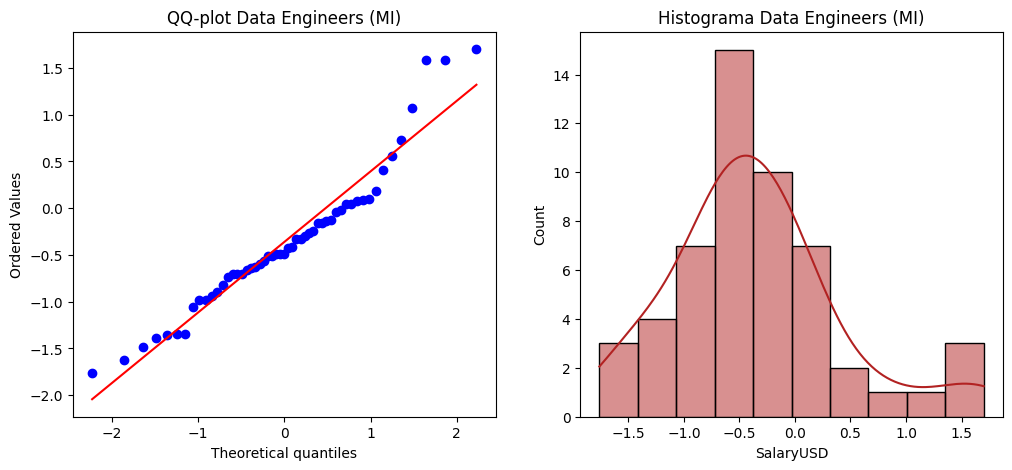

In [22]:
stat, pvalue = stats.shapiro(interDataEngineers.dropna())
print("Estadístico W:", round(stat, 4))
print("Alpha: 0.05")
print("p-value: ", round(pvalue, 4))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(interDataEngineers.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Data Engineers (MI)")

sns.histplot(interDataEngineers.dropna(), bins = 10, color="firebrick", kde = True, ax = axes[1])
axes[1].set_title("Histograma Data Engineers (MI)")

plt.show()

En el caso de los Data Engineers intermedios se observa una cola superior considerable, que provoca que el p-value de la prueba de normalidad sea menor que $\alpha = 0.05$, rechazando así la hipótesis nula que establece que los datos siguen una distribución normal. De no ser por la cola derecha, los datos se distribuirían como una normal.

### Prueba de hipótesis de varianza

Se realiza la misma prueba de varianza de Levene que en el apartado anterior para determinar si las varianzas poblacionales de ambas muestras son iguales.

In [23]:
#Prueba de varianzas entre las distribuciones
stats.levene(interDataScientists, interDataEngineers)

LeveneResult(statistic=1.453072803657262, pvalue=0.23059898826127015)

La función regresa un estadístico $t_0 = 1.9429$ con un p-value $p = 0.1662$, que sugiere que se debe rechazar la hipótesis nula y aceptar la hipótesis alternativa; las muestras provienen de poblaciones con varianzas idénticas con un nivel de confianza del 95%.

### Prueba de hipótesis

Se procede a realizar la misma prueba de hipótesis que en el caso anterior:

$H_0: ~\mu_1 = \mu_2$,

$H_1: ~\mu_1 > \mu_2$,

donde $\mu_1$ es el salario promedio de un Data Engineer, y $\mu_2$ es el salario promedio de un Data Scientist, para un $\alpha = 0.05$. No obstante, en este caso se implementará una prueba con una distribución t de Student debido al pobre ajuste de los salarios de los Data Engineers.

In [24]:
#Prueba t
t_stat, pvalue = stats.ttest_ind(a = interDataEngineers, b = interDataScientists, alternative = "greater", equal_var=True)
print("Estadístico t:", round(t_stat, 4))
print("Alpha:         0.05")
print("p-value:      ", round(pvalue, 4))

Estadístico t: 0.4575
Alpha:         0.05
p-value:       0.3241


El p-value de la prueba t es considerablemente mayor que el nivel de significancia, por lo cual no se rechaza $H_0$. Esto implica que no hay evidencia estadística suficiente para afirmar que el sueldo promedio de un Data Engineer intermedio es mayor al de un Data Scientist intermedio. El resultado anterior se vuelve intuitivo graficando las distribuciones de manera similar a la primera prueba de hipótesis

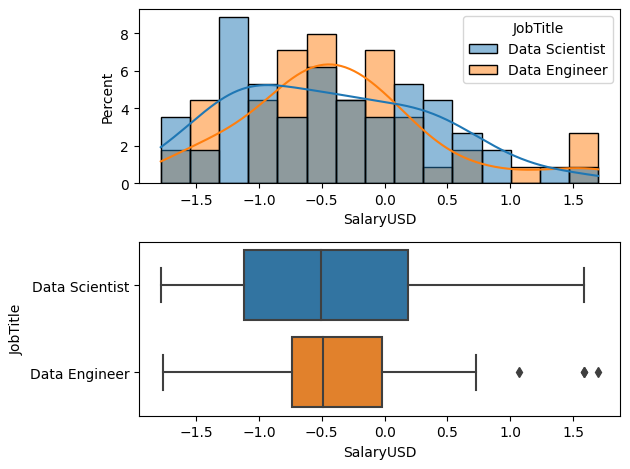

In [25]:
fig, ax = plt.subplots(2, 1)
sns.histplot(data = P1_Inter, x = "SalaryUSD", kde = True, stat = "percent", hue = "JobTitle", ax = ax[0], bins = 15)
sns.boxplot(data = P1_Inter, x = "SalaryUSD", y = "JobTitle", ax = ax[1])
plt.tight_layout()
plt.show()

# Análisis Estadístico - Pregunta 2

¿Hay diferencia significativa en el salario promedio en función de la experiencia en una empresa Estadounidense? En particular, ¿el salario promedio de un empleado intermedio es mayor que el salario promedio de un empleado principiante?

In [26]:
P2 = df.groupby("ExperienceLevel").get_group("EN")
P2 = pd.concat([P2, df.groupby("ExperienceLevel").get_group("MI")])
P2 = P2.groupby("CompanyLocation").get_group("US")
P2 = P2.drop(columns = ["WorkYear", "CompanySize"])
# P2.head(-1)

En este caso se tiene una distribución un tanto desigual de las categorías; apenas se tienen 31 registros de principiantes mientras que hay 81 registros de intermedios.

In [27]:
P2.ExperienceLevel.value_counts()

MI    87
EN    31
Name: ExperienceLevel, dtype: int64

Se extrae la media y la desviación estándar del los empleados principiantes,

In [28]:
EN_US = P2.groupby("ExperienceLevel").get_group("EN").SalaryUSD
EN_US.describe()[1:3]

mean   -0.240045
std     0.825277
Name: SalaryUSD, dtype: float64

que, en comparación con los empleados intermedios

In [29]:
MI_US = P2.groupby("ExperienceLevel").get_group("MI").SalaryUSD
MI_US.describe()[1:3]

mean    0.132211
std     0.832589
Name: SalaryUSD, dtype: float64

tienen un salario menor, con una diferencia de 0.3 desviaciones estándar de la media.

## Prueba de normalidad

De igual manera se realiza una prueba de normalidad de Shapiro-Wilk para proseguir adecuadamente con la prueba de hipótesis:

Estadístico W: 0.8474
Alpha: 0.05
p-value:  0.0004


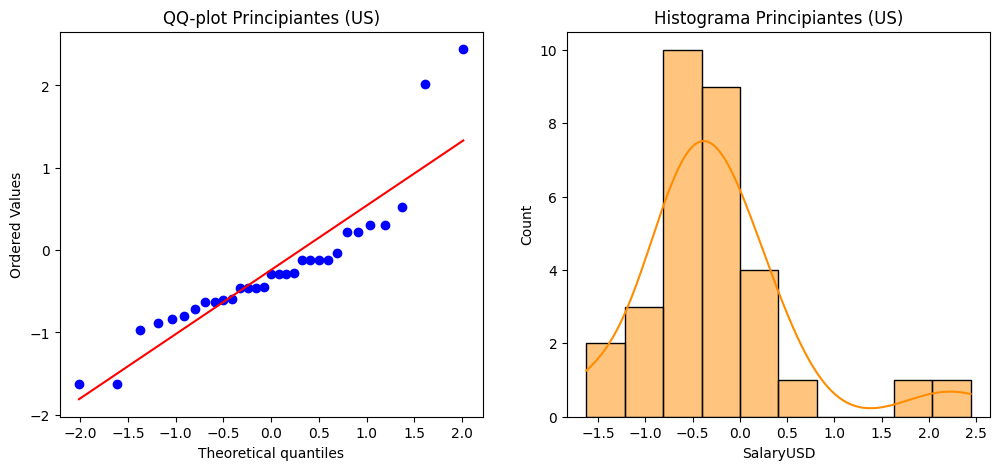

In [30]:
stat, pvalue = stats.shapiro(EN_US.dropna())
print("Estadístico W:", round(stat, 4))
print("Alpha: 0.05")
print("p-value: ", round(pvalue, 4))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(EN_US.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Principiantes (US)")

sns.histplot(EN_US.dropna(), bins = 10, color="darkorange", kde = True, ax = axes[1])
axes[1].set_title("Histograma Principiantes (US)")

plt.show()

Se obtiene un p-value mucho menor que $\alpha$ por lo cual se debe rechazar $H_0$. Por lo tanto, se dice con un nivel de significancia del 95% que los salarios empleados principiantes de empresas estadounidenses no se distribuyen como una normal. Realizando lo mismo para los intermedios,

Estadístico W: 0.9844
Alpha: 0.05
p-value:  0.3808


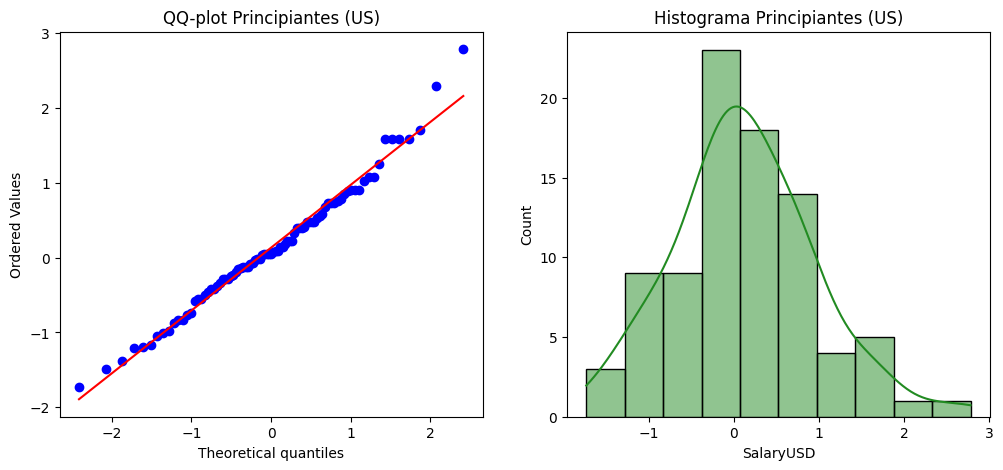

In [31]:
stat, pvalue = stats.shapiro(MI_US.dropna())
print("Estadístico W:", round(stat, 4))
print("Alpha: 0.05")
print("p-value: ", round(pvalue, 4))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(MI_US.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Principiantes (US)")

sns.histplot(MI_US.dropna(), bins = 10, color="forestgreen", kde = True, ax = axes[1])
axes[1].set_title("Histograma Principiantes (US)")

plt.show()

Se tiene el caso opuesto: el p-value es mayor que el nivel de significancia por lo cual no se rechaza $H_0$ y se dice que estos datos sí se distribuyen como una distribución normal.

## Prueba de hipótesis de varianza

También se realiza la prueba de hipótesis para comprobar la igualdad de varianzas:

In [32]:
#Prueba de varianzas entre las distribuciones
stats.levene(EN_US, MI_US)

LeveneResult(statistic=0.7427830272944111, pvalue=0.3905489611385278)

Y con el p-value retornado de $p=0.4850$ se puede decir que las distribuciones provienen de poblaciones con varianzas idénticas con un nivel de confianza del 95%.

### Prueba de hipótesis

Se procede entonces con la prueba de hipótesis:

$H_0: ~\mu_1 = \mu_2$,

$H_1: ~\mu_1 > \mu_2$,

donde $\mu_1$ es el salario promedio de un empleado de nivel Intermedio, y $\mu_2$ es el salario promedio de un empleado de nivel Principiante. Con un $\alpha = 0.05$.

In [33]:
#Prueba t
t_test, pvalue = stats.ttest_ind(a = MI_US, b = EN_US, alternative = "greater", equal_var=True)
print("Alpha: 0.05")
print("p-value: " + str(round(pvalue, 4)))

Alpha: 0.05
p-value: 0.0171


El p-value es menor que $\alpha$ por lo cual debe rechazarse la hipótesis nula, $H_0$; hay evidencia suficiente para afirmar que el salario promedio de un empleado Intermedio de una empresa estadounidense es mayor al de un empleado Principiante de una empresa estadounidense con un nivel de significancia del 95%. Se grafican ambas distribuciones para visualizar dicho resultado

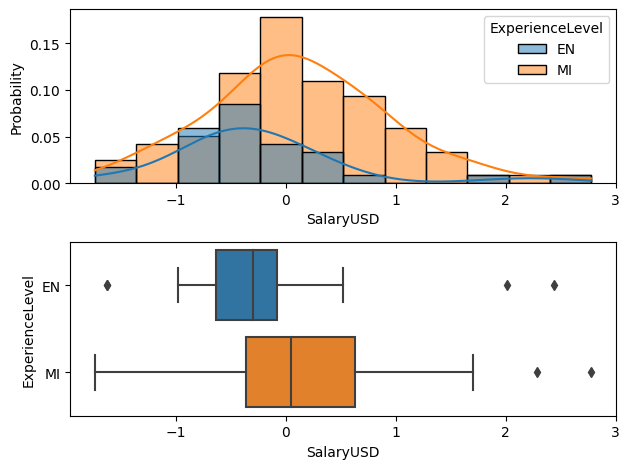

In [34]:
P2_ENvMI = pd.concat([P2.groupby("ExperienceLevel").get_group("EN"), 
                    P2.groupby("ExperienceLevel").get_group("MI")])
fig, ax = plt.subplots(2, 1)
sns.histplot(data = P2_ENvMI, x = "SalaryUSD", kde = True, stat = "probability", hue = "ExperienceLevel", ax = ax[0])
sns.boxplot(data = P2_ENvMI, x = "SalaryUSD", y = "ExperienceLevel", ax = ax[1])
plt.tight_layout()
plt.show()

# Pregunta 3

¿El salario promedio ofrecido en una empresa mediana en Estados Unidos es mayor al que ofrece una empresa mediana en Reino Unido?

In [35]:
P3 = df.groupby("CompanyLocation").get_group("US")
P3 = pd.concat([P3, df.groupby("CompanyLocation").get_group("GB")])
P3 = P3.drop(columns = ["WorkYear", "ExperienceLevel", "JobTitle"])
# P3.head(-1)

Se observa la distribución de las categorías de este caso:

In [36]:
P3.CompanyLocation.value_counts()

US    345
GB     47
Name: CompanyLocation, dtype: int64

Hay 343 empresas Estadounidenses y solo 47 empresas de Reino Unido. Desglosando los tamaños de las empresas de Estados Unidos,

In [37]:
P3.groupby("CompanyLocation").get_group("US").CompanySize.value_counts()

M    216
L     99
S     30
Name: CompanySize, dtype: int64

resalta el hecho de que preponderan las empresas medianas con 216 registros (62.97%), seguidas por las empresas grandes con 97 registros (28.28%), y finalmente están las empresas pequeñas estadounidenses con 30 registros (8.75%). Se hace lo mismo para el Reino Unido

In [38]:
P3.groupby("CompanyLocation").get_group("GB").CompanySize.value_counts()

M    31
L    11
S     5
Name: CompanySize, dtype: int64

resultando en una distribución similar en el mismo orden: 31 registros de empresas medianas (65.96%), 11 de empresas grandes (23.40%), y tan solo 5 registros de empresas pequeñas (10.64%). Extraemos el grupo de interés, las empresas medianas:

In [39]:
P3 = P3.groupby("CompanySize").get_group("M")
# P3.head(-1)

Se calcula la media y la desviación estándar de los salarios de las empresas medianas estadounidenses:

In [40]:
US_M = P3.groupby("CompanyLocation").get_group("US")["SalaryUSD"]
US_M.describe()[1:3]

mean    0.546564
std     0.786323
Name: SalaryUSD, dtype: float64

Luego se obtienen las mismas medidas para el subconjunto de Reino Unido:

In [41]:
GB_M = P3.groupby("CompanyLocation").get_group("GB")["SalaryUSD"]
GB_M.describe()[1:3]

mean   -0.443580
std     0.549417
Name: SalaryUSD, dtype: float64

Al echar un vistazo a las medias se vuelve evidente la gran diferencia entre ambos valores; difieren por casi 1 desviación estándar de la media de salarios.

## Prueba de normalidad

Una vez más, se realiza la prueba de normalidad de Shapiro-Wilk para determinar la distribución a utilizar en la prueba de hipótesis. Empezando por el subconjunto de empresas medianas estadounidenses:

Estadístico W: 0.9896
Alpha: 0.05
p-value:  0.1207


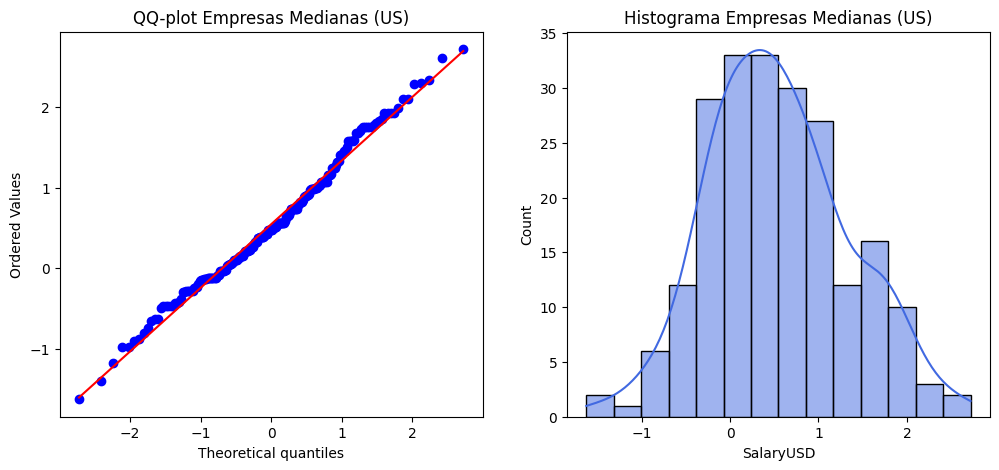

In [42]:
stat, pvalue = stats.shapiro(US_M.dropna())
print("Estadístico W:", round(stat, 4))
print("Alpha: 0.05")
print("p-value: ", round(pvalue, 4))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(US_M.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Empresas Medianas (US)")

sns.histplot(US_M.dropna(), bins = 14, color="royalblue", kde = True, ax = axes[1])
axes[1].set_title("Histograma Empresas Medianas (US)")

plt.show()

Se observa un buen ajuste la recta teórica, una buena forma del histograma, y el consecuente p-value de $0.1207 > \alpha$; por tanto, se concluye que este vector sigue una distribución normal. Lo siguiente es la prueba del subconjunto británico:

Estadístico W: 0.9182
Alpha: 0.05
p-value:  0.0211


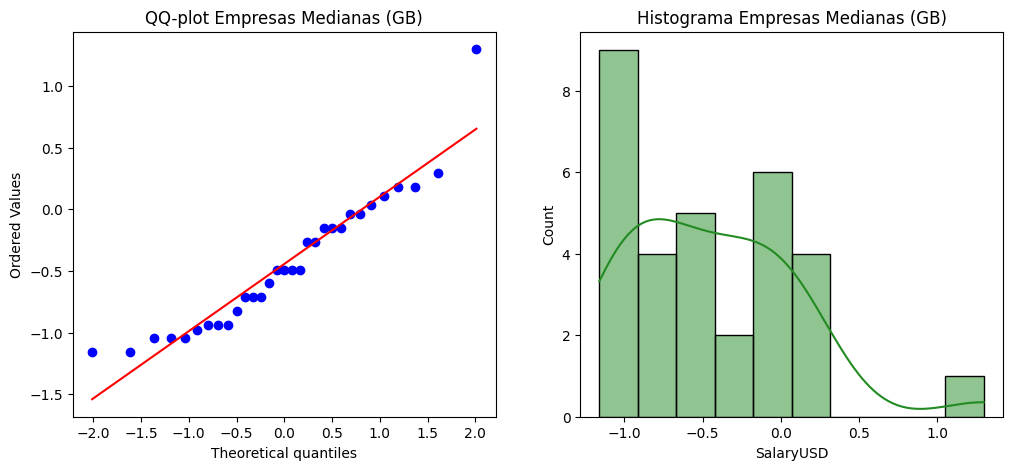

In [43]:
stat, pvalue = stats.shapiro(GB_M.dropna())
print("Estadístico W:", round(stat, 4))
print("Alpha: 0.05")
print("p-value: ", round(pvalue, 4))

fig, axes = plt.subplots(1,2, figsize = (12,5))

stats.probplot(GB_M.dropna(), fit = True, plot = axes[0])
axes[0].set_title("QQ-plot Empresas Medianas (GB)")

sns.histplot(GB_M.dropna(), bins = 10, color="forestgreen", kde = True, ax = axes[1])
axes[1].set_title("Histograma Empresas Medianas (GB)")

plt.show()

En este caso se tiene una forma del histograma con un sesgo importante, lo cual repercute en las colas de los cuantiles teóricos, afectando el ajuste; se obtiene un p-value de $p = 0.0211$, y, con un nivel de significancia de $\alpha = 0.05$ se sigue necesariamente el rechazo de la hipótesis nula; por lo tanto, se dice que el subconjunto de empresas medianas de Reino Unido no sigue una distribución normal.

## Prueba de hipótesis de varianza

De manera reiterada, se debe poner a prueba si las varianzas iguales; la intención de tal procedimiento es utilizar los argumentos y funciones indicadas para la prueba de hipótesis de dos muestras. Esto se realiza con la prueba de Levene.

In [44]:
#Prueba de varianzas entre las distribuciones
l_stat, l_pvalue = stats.levene(US_M, GB_M)
print("Alpha: 0.05")
print("p-value: " + str(round(l_pvalue, 4)))

Alpha: 0.05
p-value: 0.0342


La prueba retorna un p-value menor que $\alpha$, por lo cual debe rechazarse $H_0$. Dicho resultado implica que las muestras no provienen de poblaciones con varianzas idénticas con un nivel de confianza del 95%.

## Prueba de hipótesis

Finalmente, se plantean las hipótesis a probar:

$H_0: ~\mu_1 = \mu_2$,

$H_1: ~\mu_1 > \mu_2$,

donde $\mu_1$ es el salario promedio que ofrece una empresa mediana Estadounidense, y $\mu_2$ es el salario promedio que ofrece una empresa mediana Británica. Las pruebas se realican con un $\alpha = 0.05$. Se debe ajustar la prueba t para que se tome en cuenta las varianzas diferentes de las muestras.

In [45]:
#Prueba t
t_test, pvalue = stats.ttest_ind(a = US_M, b = GB_M, alternative = "greater", equal_var=False)
print("Estadístico t:", t_test)
print("Alpha: 0.05")
print("p-value: " + str(round(pvalue, 6)))

Estadístico t: 8.820932373780632
Alpha: 0.05
p-value: 0.0


La prueba resulta en un estadístico $t_0$ muy grande y, de forma consecuente, un p-value extremadamente pequeño; por esta razón se rechaza $H_0$. En consecuencia, puede afirmarse con un nivel de significancia del 95% que el salario que ofrece una empresa mediana de Estados Unidos, en promedio, es mayor al que ofrece una empresa de Reino Unido, en promedio. Dicha conclusión se aprecia en la visualización del histograma y el diagrama de caja.

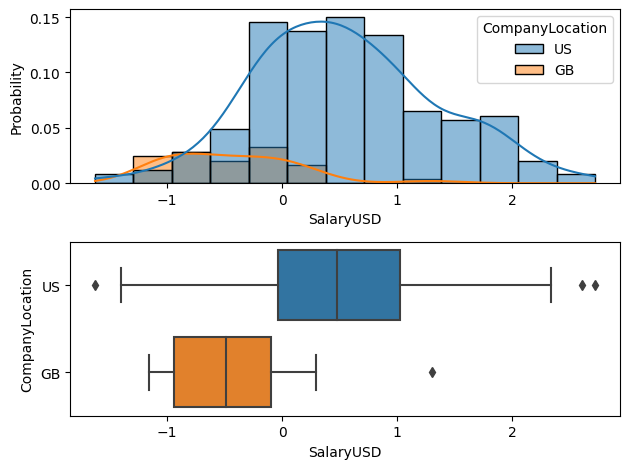

In [46]:
fig, ax = plt.subplots(2, 1)
sns.histplot(data = P3, x = "SalaryUSD", kde = True, stat = "probability", hue = "CompanyLocation", ax = ax[0])
sns.boxplot(data = P3, x = "SalaryUSD", y = "CompanyLocation", ax = ax[1])
plt.tight_layout()
plt.show()

# Conclusión

El análisis anterior permite hacer varias conclusiones. Primero, puede afirmarse que no hay diferencia significativa entre el salario promedio de un Data Engineer y un Data Scientist para el mismo nivel de experiencia: nivel intermedio. No obstante, esta conclusión lleva en realidad varios asteriscos; debido a que no se realizó un ANOVA con las variables categóricas (puesto, nivel de experiencia, año, ubicación de la empresa, etc.) es imposible realizar esta misma afirmación con seguridad si se desagrega para el resto de los factores. Para investigaciones posteriores sería pertinente realizar este análisis para determinar con certeza los factores principales, y si, en efecto, la presente conclusión se mantiene sólida. 

Se encontró también que el salario promedio de un empleado intermedio en una empresa Estadounidense es mayor al de un empleado principiante. Los mismos asteriscos de la conclusión anterior aplican aquí. 

Finalmente, se encontró que el salario promedio ofrecido por una empresa mediana en Estados Unidos es mayor que el de una empresa mediana en Reino Unido. Vale la pena tomar las mismas precauciones que en los dos casos anteriores. 

# Enlace al repositorio de Github

[GitHub con el Notebook y la base de datos](https://github.com/crisb-7/Data-Science-Salaries)